## Задача исследования

**Задача** - построить модель для определения стоимости автомобиля на основе исторических данных о технических характеристиках, комплектации и цене автомобилей.

**Критерии оценки:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Метрика оценки качества:**

- RMSE < 2500 

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

## План исследования с выводами

## 1. Загрузка и обзор данных
- Успешно загружено **354 369 записей** и **15 признаков**.
- Данные охватывают период с **10.03.2014 по 07.04.2016**.
- Обнаружены:
  - Пропуски: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`
  - Аномалии: `price`, `registration_year`, `power`, `registration_month`
  - Константа: `number_of_pictures` — всегда 0
  - Полные дубликаты — удалены (4 шт.)

## 2. Подготовка данных

### 2.1 Преобразования
- Признаки приведены к `snake_case`
- Типы данных оптимизированы для экономии памяти:
  - `int64 → int16`
  - `object → category`

### 2.2 Заполнение пропусков
- `model`: `'missing'`
- `vehicle_type`, `gearbox`, `fuel_type`: мода по `model`
- `repaired`: `'yes'` при пробеге > 100 тыс. км, иначе `'missing'`

### 2.3 Обработка аномалий
- `price = 0` — записи удалены
- `registration_year < 1980` — заменены на `NaN`
- `power < 50` или `> 350` — заменены модой по `model`
- `registration_month = 0` — заменён на 1 или 12 (поровну)

## 3. Исследовательский анализ данных (EDA)

### Ключевые наблюдения:
- Большинство авто **старше 10 лет** и с пробегом **более 125 тыс. км**
- Популярные кузова: **седан**, **маленький**, **универсал**
- Основные бренды: **Volkswagen**, **Opel**, **BMW**
- Чаще всего: **механическая коробка**, **бензин**, **мощность от 50 до 150 л.с.**
- Цена имеет **логнормальное распределение**

### Корреляционный анализ:
- Мультиколлинеарность между: `model`, `brand`, `power`, `vehicle_type`
- Оставлены только признаки с наибольшей корреляцией с целевым:
  - `model` (0.57)
  - `registration_year`
  - `repaired`
- Удалены: `brand`, `power`, `vehicle_type`

## 4. Построение и обучение моделей

### Обучаемые модели:
- **Линейные**: Ridge, Lasso, ElasticNet
- **Бустинг**: CatBoost, LightGBM
- **Метрические**: KNN, SVR

### Подход:
- Использование пайплайнов (preprocessing + model)
- Подбор гиперпараметров: `RandomizedSearchCV`
- Оценка на тестовой выборке

## 5. Оценка результатов

- **Победитель: `LGBMRegressor`**
  - RMSE = **2080**
  - Обучение: **6.37 сек**, Предсказание: **0.24 сек**
  - RMSE < 2500 ✅

### Feature Importance:
- Самые важные признаки:
  - `model`
  - `registration_year`
  - `kilometer`
  - `repaired`

### SHAP-анализ:
- Подтверждает значимость признаков из `feature_importance`

### Анализ остатков:
- **Гетероскедастичность** — остатки нерегулярны, особенно в среднем диапазоне
- **Отсутствие смещения** — остатки симметричны относительно нуля

---

# Общий вывод по исследованию

- Задача предсказания стоимости автомобиля решена успешно.
- Все этапы — от загрузки данных до построения модели — выполнены качественно.
- **LGBMRegressor** показал наилучший баланс между качеством и скоростью.
- Целевая метрика RMSE достигла **2080**, что значительно лучше заданного порога в **2500**.
- Ключевыми признаками оказались: **модель**, **возраст**, **пробег**, **ремонт**.
- Модель может быть использована в продакшн с последующей оптимизацией и устранением гетероскедастичности.

## Импорт бибилиотек и чтение (обзор) данных

### Иморт бибилиотек

In [1]:
#!pip install phik -q
#!pip install shap -q
#!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import time

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split,
    KFold,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    TargetEncoder,
    FunctionTransformer

)

from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from sklearn.inspection import permutation_importance

seed = 42

### Чтение и обзор данных

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', 
                 parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

display(df.head(3))
df.shape

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


(354369, 16)

**Функция отображения общей информации**

In [4]:
def df_summary(name: str, df: pd.DataFrame) -> None:
    """
    Функция df_summary принимает на вход str DataFrame и выводит три сводные таблицы с общей информацией:
    
    1. Первая таблица содержит:
       - Первые пять строк датафрейма
    
    2. Вторая таблица содержит:
       - Общее количество строк
       - Общее количество столбцов
       - Количество полных дубликатов строк
    
    я. Третяя таблица содержит информацию о каждом признаке:
       - Название признака
       - Количество пропусков для каждого признака
       - Количество уникальных значений для каждого признака
       - Тип данных каждого признака

    Параметры:
    name (str): Входная строка - название датафрейма;
    df (pd.DataFrame): Входной датафрейм, для которого нужно сформировать сводные таблицы.

    Возвращаемое значение:
    None. Функция выводит таблицы напрямую.
    """ 
    
    # Таблица 1: общее число строк, столбцов и дубликатов
    total_rows = df.shape[0]
    total_columns = df.shape[1]
    total_duplicates = df.duplicated().sum()
    
    summary_1 = pd.DataFrame({
        'Число строк': [total_rows],
        'Число признаков': [total_columns],
        'Число полных дубликатов': [total_duplicates]
    })
    summary_1_t = summary_1.T
    summary_1_t.columns = ['Значение']

    # Таблица 2: информация о каждом признаке
    summary_2 = pd.DataFrame({
        'Признак': df.columns,
        'Число пропусков': df.isnull().sum(),
        'Число уникальных': df.nunique(),
        'Тип': df.dtypes
    }).reset_index(drop=True)
    

    # Вывод таблиц
    print(f'Таблица: {name}', sep='\n')
    
    print('', 'Обзор данных', sep='\n')
    display(df)
    
    print('', 'Статистика признаков', sep='\n')
    display(df.describe())
    
    print('', 'Общая информация', sep='\n')
    display(summary_1_t)
    
    print('', 'Информация о признаках',sep='\n')
    display(summary_2)
    
    print('', '', sep='\n')
    
    # Вывод уникальных значений признаков
    print('Уникальные значения признаков')
    for col in df.columns:
        print('', col, df[col].sort_values().unique(), sep='\n')
    

In [5]:
df_summary('overall_data', df)

Таблица: overall_data

Обзор данных


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26



Статистика признаков


,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN



Общая информация


,Значение
Число строк,354369
Число признаков,16
Число полных дубликатов,4



Информация о признаках


,Признак,Число пропусков,Число уникальных,Тип
0,DateCrawled,0,271174,datetime64[ns]
1,Price,0,3731,int64
2,VehicleType,37490,8,object
3,RegistrationYear,0,151,int64
4,Gearbox,19833,2,object
5,Power,0,712,int64
6,Model,19705,250,object
7,Kilometer,0,13,int64
8,RegistrationMonth,0,13,int64
9,FuelType,32895,7,object




Уникальные значения признаков

DateCrawled
<DatetimeArray>
['2016-03-05 14:06:22', '2016-03-05 14:06:23', '2016-03-05 14:06:24',
 '2016-03-05 14:06:25', '2016-03-05 14:06:26', '2016-03-05 14:06:27',
 '2016-03-05 14:06:28', '2016-03-05 14:06:29', '2016-03-05 14:06:30',
 '2016-03-05 14:06:40',
 ...
 '2016-04-07 14:36:42', '2016-04-07 14:36:43', '2016-04-07 14:36:44',
 '2016-04-07 14:36:45', '2016-04-07 14:36:46', '2016-04-07 14:36:53',
 '2016-04-07 14:36:54', '2016-04-07 14:36:55', '2016-04-07 14:36:56',
 '2016-04-07 14:36:58']
Length: 271174, dtype: datetime64[ns]

Price
[    0     1     2 ... 19998 19999 20000]

VehicleType
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

RegistrationYear
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 19

### Промежуточные выводы

1. данные загружены корректно и соответствуют описанию
2. в данных 354369 записей и 15 признаков
3. данные содержат информацию об объявлениях за период с 10.03.2014 по 07.04.2016
4. в данных обнаружены:
    - 4 полных дубликата
    - пропуски в признаках: vehicle_type, gearbox, model, fuel_type, repaired
    - аномальные значения в признаках price, registration_year, power, registration_month
    - константное значение (0) в признаке number_of_pictures
4. структура данных позволяет оптимизировать типы данных с целью снижения потребляемой памяти (int64 -> int16; object -> category)
    

## Подготовка данных

### Форматирование наименований признаков

In [6]:
df.columns = df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Унификация форматов значений

In [7]:
def formating(df):
    df.info(memory_usage='deep')
    
    num_cols = df.select_dtypes(include='number').columns
    cat_cols = df.select_dtypes(include='object').columns

    for col in num_cols:
        df[col] = df[col].astype('int32', errors='ignore')

    for col in cat_cols:
        df[col] = (df[col]
                   .str.strip()
                   .str.lower()
                   .str.replace(r"\s+", " ", regex=True) # несколько пробелов в один
                   #.astype('category')                 
                  )   
        
    df.info(memory_usage='deep')

formating(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Удаление полных дубликатов

In [8]:
display(df.shape)
df.drop_duplicates(inplace=True)
df.shape

(354369, 16)

(354365, 16)

### Устранение пропусков

In [9]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

**model**

Заполнить пропущенные значения в признаке модели автомобиля на основе других признаков затруднительно, поэтому заменим их на фиксированное значение 'missing'

In [10]:
df['model'] = df['model'].fillna(df['brand'])

In [11]:
df['model'].isna().sum()

np.int64(0)

**vehicle_type, gearbox, fuel_type**

Пропущенные значения в признаках: тип кузова автомобиля, тип КПП и тип топливной системы имеет смысл заполнить наиболее часто встречающимся значением в группе соответствующей модели автомобиля. Часть пропусков будут заполнены значением missing по причине отсутствия информации о модели авто.

In [12]:
columns_to_model = [
    'vehicle_type',
    'gearbox',
    'fuel_type'
]

for col in columns_to_model:
    df[col] = df[col].fillna(
        df.groupby('model')[col].transform(
            lambda x: x.mode()[0] if not x.mode().empty else 'missing'))

In [13]:
df[columns_to_model].isna().sum()

vehicle_type    0
gearbox         0
fuel_type       0
dtype: int64

**repaired**

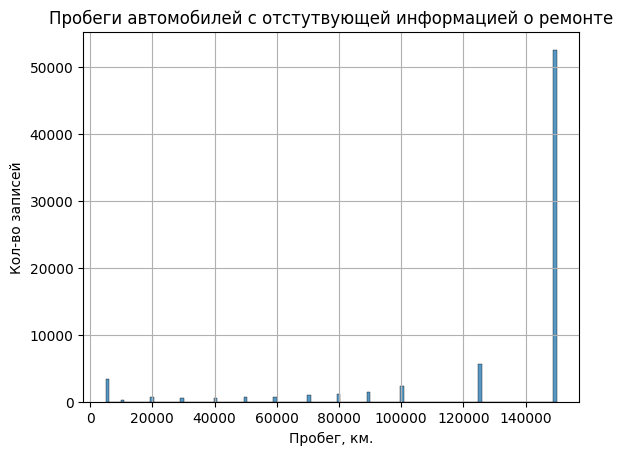

In [14]:
sns.histplot(df[df['repaired'].isna()]['kilometer'])
plt.title('Пробеги автомобилей с отстутвующей информацией о ремонте')
plt.xlabel('Пробег, км.')
plt.ylabel('Кол-во записей')
plt.grid()
plt.show()

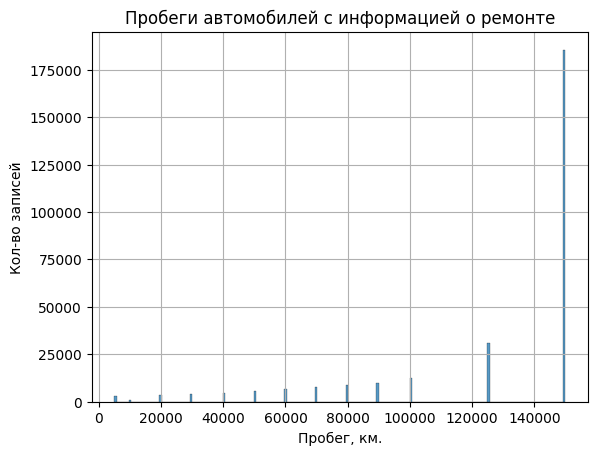

In [15]:
sns.histplot(df[~df['repaired'].isna()]['kilometer'])
plt.title('Пробеги автомобилей с информацией о ремонте')
plt.xlabel('Пробег, км.')
plt.ylabel('Кол-во записей')
plt.grid()
plt.show()

Из имеющихся данных и из логических соображений заметим, что чем больше пробег авто тем выше вероятность ремонтных мероприятий. Согласно предоставленным данным в основном ремонту подвергались автомобили с пробегом 100+ тыс. км. Исходя из этого пропущеные значения для авто с пробегом 100+ тыс. км. заполним значением 'yes', остальные заполним заглушкой 'missing'.

In [16]:
df.loc[df['kilometer'] >= 100000, 'repaired'] = 'yes'
df['repaired'].fillna('missing', inplace=True)

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_19804\2898763722.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['repaired'].fillna('missing', inplace=True)


In [17]:
df['repaired'].isna().sum()

np.int64(0)

### Обработка аномальных значений

В следующих признаках наблюдаются аномальные значения:
1. признак цена автомобиля - значения с нулевой ценой
2. год регистрации автомобиля - даты ранее даты изобретения автомобиля (1885) и после последней даты сбора информации
3. мощность ДВС - значения превышающие 300-400 л.с. не свойственны исследуемым автомобилям  
4. месяц регистрации - уникальных значений 13

В данных присутствует признак кол-во фотографий с константным значением не привносящий никакой полезной информации.

In [18]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Устранение аномалий

**price (целевой признак)**

In [19]:
df['price'].value_counts()[:5]

price
0       10772
500      5670
1500     5394
1000     4648
1200     4594
Name: count, dtype: int64

В данных встречаются значения равные нулю, что вызывает сомнения. Вряд ли авто раздают как подарки. Возможно 2 варианта устранения данной неточности: ислключить записи из дальнейшего анализа (незначительное кол-во таких записей позволяет) или заполнить каим либо способом (среднее, медиана) по группе в которыую входит автомобиль. 

**registration_year**

In [20]:
first_year = 1980
last_crawled_year = df['date_crawled'].dt.year.max()
last_crawled_month = df['date_crawled'].dt.month.max()

df[(df['registration_year'] < first_year) | 
   ((df['registration_year'] > last_crawled_year) & 
   (df['registration_month'] > last_crawled_month))
]['power'].count()

np.int64(10571)

In [21]:
df.loc[(df['registration_year'] < first_year) | 
       ((df['registration_year'] > last_crawled_year) & 
       (df['registration_month'] > last_crawled_month)), 'registration_year'
] = 1000

**power**

In [22]:
df[(df['power'] < 50) | (df['power'] > 350)].groupby('power')['power'].count()

power
0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 417, dtype: int64

В данных присутствуют аномальные значения для исправления которых необходимо привлечь специалиста обладающего знаниями в области авторынка. На данном этапе допустим, что мощность автомобилей представленных в данных, лежит в диапозоне от 50 до 350 лошадинных сил. Все значения за пределами этого диапазона заполним наиболее часто встречающимся (мода) значением по каждой модели.

In [23]:
df['power'] = df['power'].where((df['power'] >= 50) & (df['power'] <= 350), np.nan)

In [24]:
df['power'] = df['power'].fillna(
        df.groupby('model')['power'].transform(
            lambda x: x.mode()[0] if not x.mode().empty else -1))

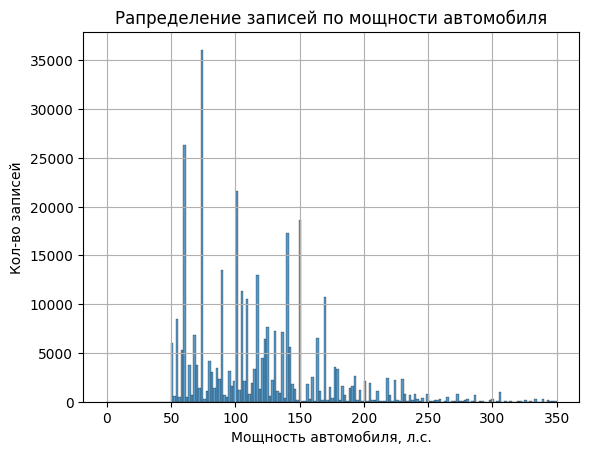

In [25]:
sns.histplot(df['power'])
plt.title('Рапределение записей по мощности автомобиля')
plt.xlabel('Мощность автомобиля, л.с.')
plt.ylabel('Кол-во записей')
plt.grid()
plt.show()

**Признаки с датами**

In [26]:
incorrect_dates = df[(df['registration_year'] > df['last_seen'].dt.year) |     # регистрация авто позже даты последнего логин-а пользователя
   (df['registration_year'] > df['date_created'].dt.year) |  # дата регистрации авто позже даты создания объявления
   (df['registration_year'] > df['date_crawled'].dt.year) |  # регистрация автомобиля позже даты сбора данных
   (df['last_seen'] > df['date_crawled']) |                  # последний логин пользователя после даты сбора данных
   (df['last_seen'] < df['date_created']) |                  # дата создания объявления позже даты последнего логин-а пользователя 
   (df['last_seen'].dt.year < df['registration_year']) |     # дата последнего логин-а пользователя позде даты регистрации авто
   (df['date_created'] > df['date_crawled']) |               # дата создания объявления позже даты сбора данных
   (df['date_created'] > df['last_seen']) |                  # дата создания объявления позже последнего логин-а пользователя
   (df['date_created'].dt.year < df['registration_year'])    # дата создания объявления позже даты регистрации автомобиля
]

display(incorrect_dates.sample(3)), incorrect_dates.shape

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
275211,2016-04-04 01:57:50,14390,wagon,2013,manual,136.0,c_klasse,150000,9,gasoline,mercedes_benz,yes,2016-04-04,0,54292,2016-04-06 09:44:24
126759,2016-03-23 18:59:51,1990,suv,1999,auto,194.0,pajero,150000,12,petrol,mitsubishi,yes,2016-03-23,0,50825,2016-03-31 06:46:48
330448,2016-03-22 13:38:57,650,small,2003,manual,60.0,corsa,150000,3,petrol,opel,yes,2016-03-22,0,7330,2016-03-29 16:44:51


(None, (318789, 16))

## Генерирование признаков

**Почтовый индекс**

In [27]:
df['postal_code'].min(), df['postal_code'].max()

(np.int32(1067), np.int32(99998))

In [28]:
df['postal_code_1'] = df['postal_code'].astype(str).apply(lambda x: x[0] if len(x) == 5 else 0).astype('int32')
df['postal_code_2'] = df['postal_code'].astype(str).apply(lambda x: x[:2] if len(x) == 5 else '0' + x[0]).astype('int32')
df['postal_code_3'] = df['postal_code'].astype(str).apply(lambda x: x[:3] if len(x) == 5 else '0' + x[:2]).astype('int32')
df['postal_code_4'] = df['postal_code'].astype(str).apply(lambda x: x[:4] if len(x) == 5 else '0' + x[:3]).astype('int32')

In [29]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,postal_code_1,postal_code_2,postal_code_3,postal_code_4
0,2016-03-24 11:52:17,480,sedan,1993,manual,75.0,golf,150000,0,petrol,volkswagen,yes,2016-03-24,0,70435,2016-04-07 03:16:57,7,70,704,7043
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,audi,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,6,66,669,6695
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,yes,2016-03-14,0,90480,2016-04-05 12:47:46,9,90,904,9048
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,yes,2016-03-17,0,91074,2016-03-17 17:40:17,9,91,910,9107
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,6,60,604,6043


## Исследовательский анализ данных

In [30]:
df_clean = df[df['price'] != 0]

**Функция визуализации количественных и категориальных признаков**

In [31]:
def visualise_all(df):
    # Выделяем числовые и категориальные колонки
    num_cols = df.select_dtypes(include='number').columns
    cat_cols = df.select_dtypes(include='category').columns

    # Статистика
    display(df.describe())
    
    
    # Визуализация числовых колонок
    for col in num_cols:
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f'Распределение: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.tight_layout()
        plt.show()

    # Визуализация категориальных колонок
    for col in cat_cols:
        sns.countplot(data=df, x=col, order=df[col].value_counts().index[:10])
        plt.title(f'Распределение категорий: {col}')
        plt.xlabel(col)
        plt.ylabel('Кол-во записей')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen,postal_code_1,postal_code_2,postal_code_3,postal_code_4
count,343593,343593.000000,343593.000000,343593.000000,343593.000000,343593.000000,343593,343593.0,343593.000000,343593,343593.000000,343593.000000,343593.000000,343593.000000
mean,2016-03-21 12:55:04.584723968,4555.147363,1974.973419,117.975215,128337.815380,5.777897,2016-03-20 19:06:21.936768512,0.0,50683.169852,2016-03-30 00:50:33.329043200,4.569398,50.236902,506.343956,5067.809507
min,2016-03-05 14:06:22,1.000000,1000.000000,-1.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08,0.000000,1.000000,10.000000,106.000000
25%,2016-03-13 11:49:14,1200.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30449.000000,2016-03-23 06:16:50,3.000000,30.000000,304.000000,3044.000000
50%,2016-03-21 17:49:25,2890.000000,2003.000000,109.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49525.000000,2016-04-03 16:51:24,4.000000,49.000000,495.000000,4952.000000
75%,2016-03-29 14:38:32,6500.000000,2007.000000,144.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71229.000000,2016-04-06 10:16:10,7.000000,71.000000,712.000000,7122.000000
max,2016-04-07 14:36:58,20000.000000,9999.000000,350.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51,9.000000,99.000000,999.000000,9999.000000
std,NaN,4515.076200,184.605658,50.757464,37520.773792,3.698197,NaN,0.0,25744.210591,NaN,2.556804,25.756561,257.433083,2574.444699


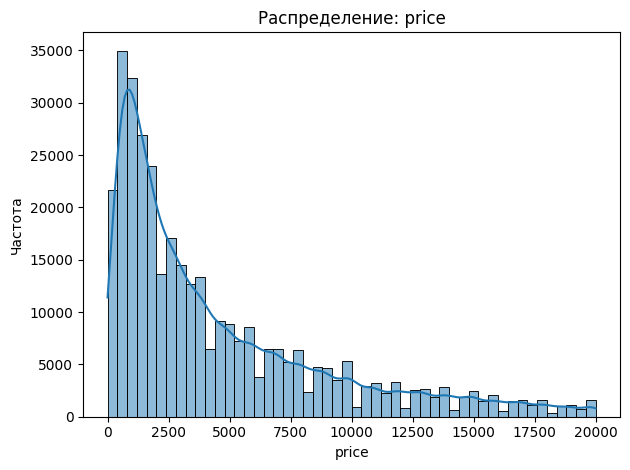

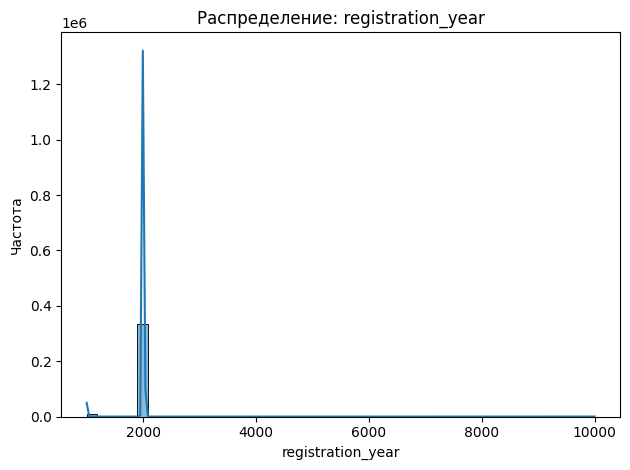

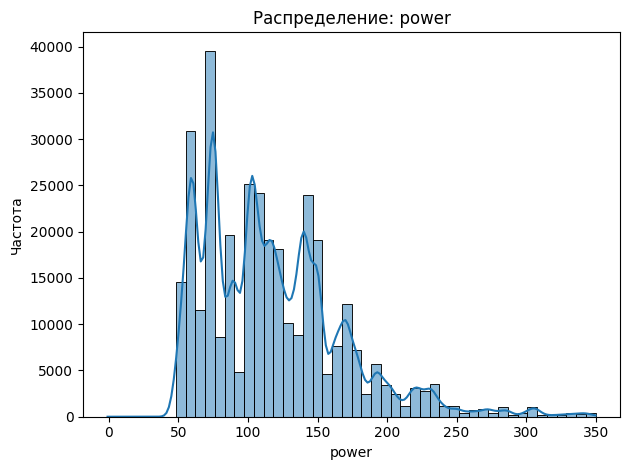

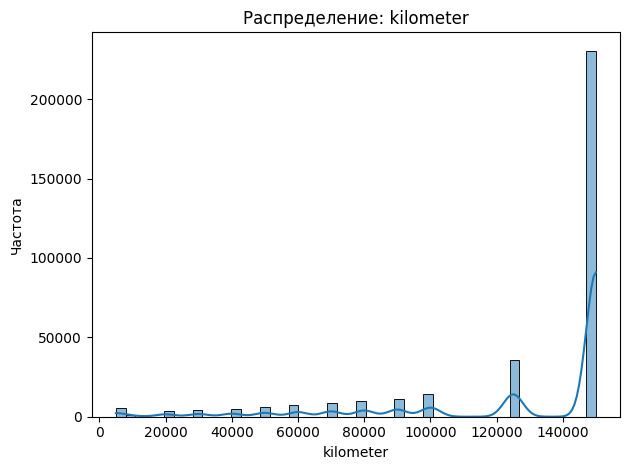

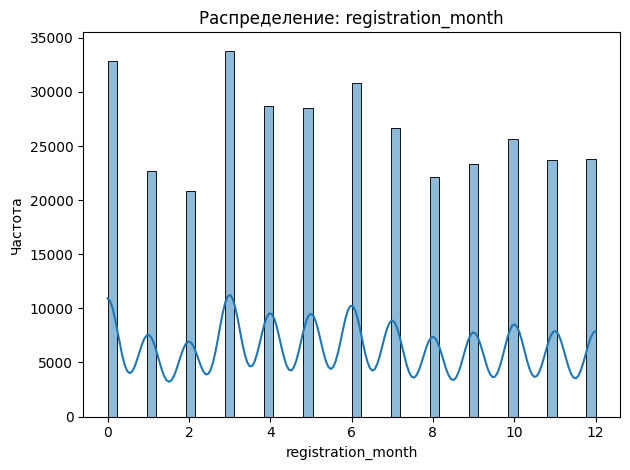

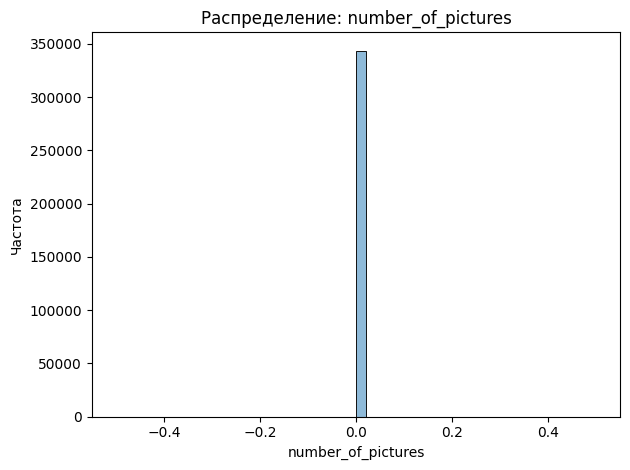

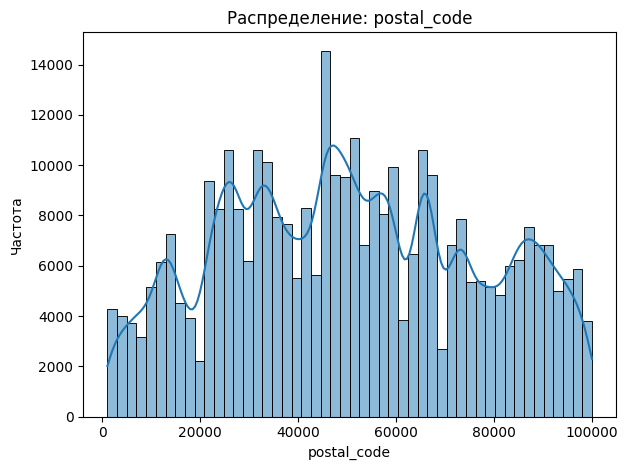

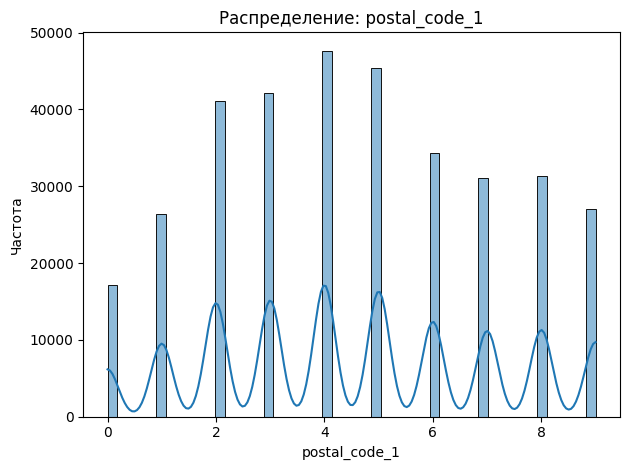

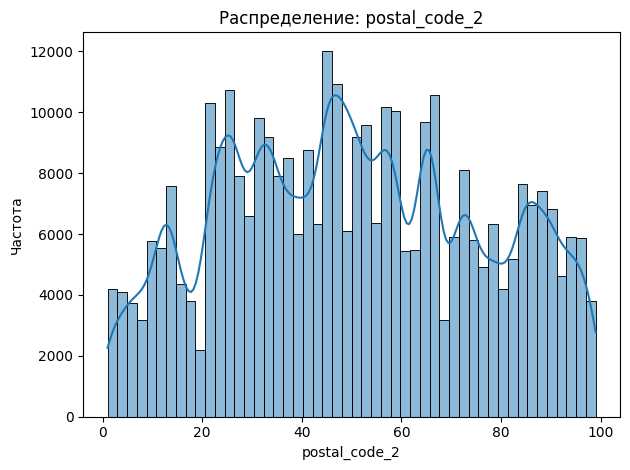

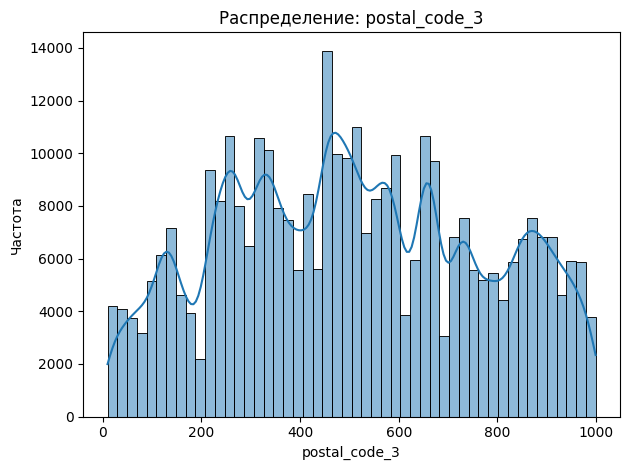

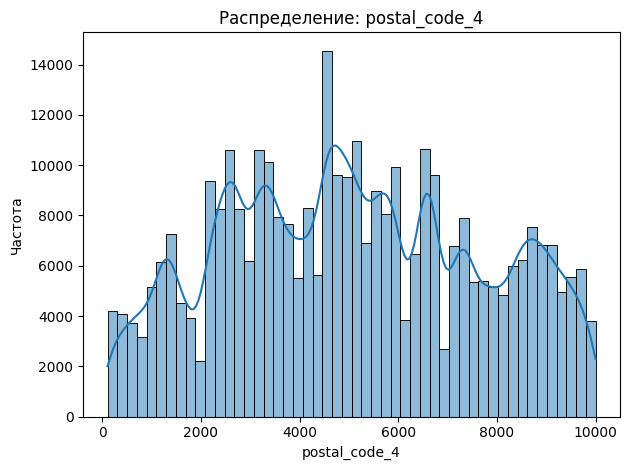

In [32]:
visualise_all(df_clean)

Перед нами, датасет состоящий из объявлений на продажу автомобилей:

    - преимущественно старых (более половины авто возрастом более 10 лет) и с большим пробегом (более половины с пробегом более 125т ыс. км.);
    - стоимость автомобилей согласуется с пробегом и возрастом;
    - наиболее популярные типы кузова седан, маленький или универвал;
    - большая часть авто отноист к брендам volkswagen, opel или bmw и моделям golf, прочие и 3er;
    - большая часть автомобилей с ручной КПП, с бензиновым двигателем мощностью от 50 до 150 л.с. и на удивление не побывавшие ни разу в ремонте (может этим и обусловлена средняя стоимость)
    - цена автомоблией (целевой признак) сформирован логнормальным распределением

### Корреляционный анализ

In [33]:
# исключим признаки не представляющие интерес для прогноза цены автомобиля
df_clean_ = df_clean.drop([
    'date_crawled',
    'date_created',
    'last_seen',
    'number_of_pictures'  
], axis=1)

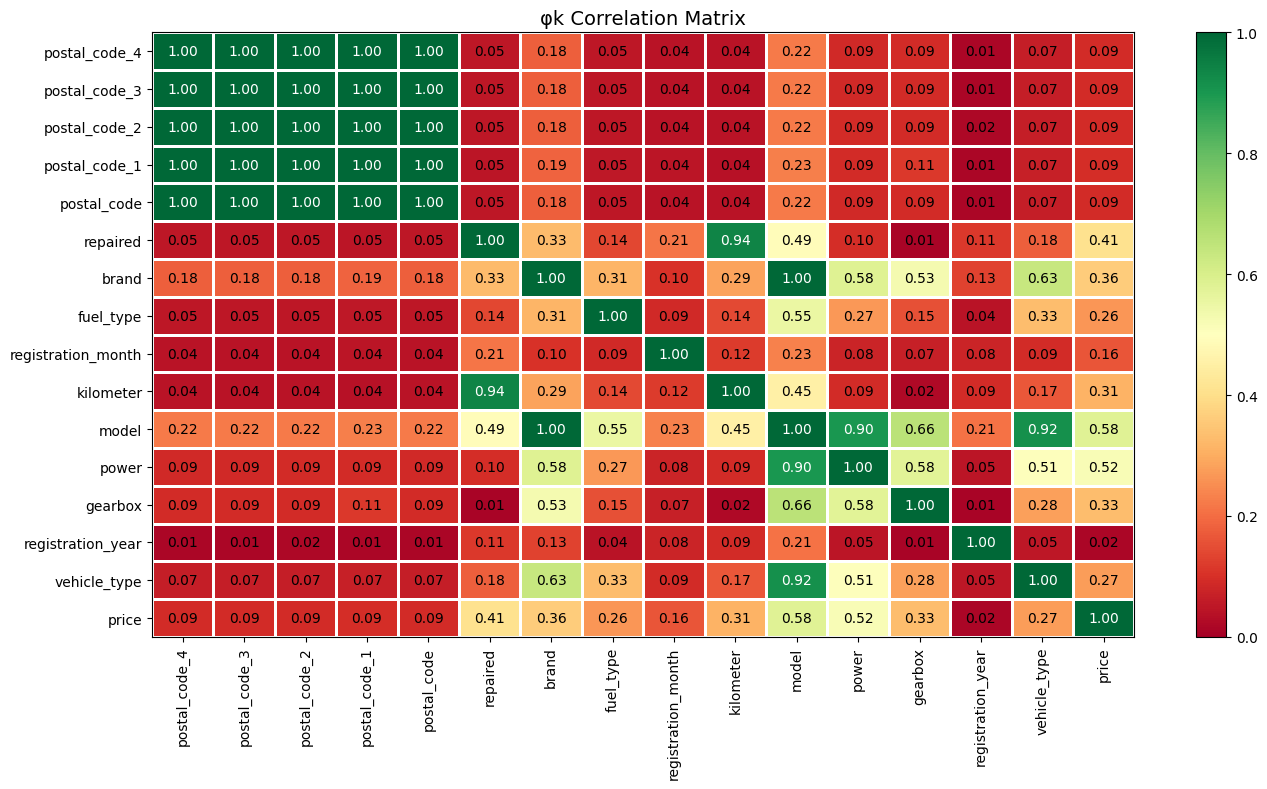

In [34]:
# Расчёт phi_k матрицы
phik_matrix = df_clean_.phik_matrix(
    interval_cols=df.drop('registration_month', axis=1).select_dtypes(include='number')
)

plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1,
    title="φk Correlation Matrix",
    figsize=(14, 8)
)
plt.tight_layout()
plt.show();

В данны наблюдается мультиколлинеарность между признаком model и brand, power и vehicle_type. 
Среди всех этих признаков наибольшая корреляция с целевым признаком наблюдается у признака model (0.57 против 0.36, 0.52 и 0.27), поэтому для устранения мультиколлинеарности исключим признаки brand, power и vehicle_type из датасета отправляемого в модели для обучения.

Наибольшая корреляция с целевым признаком наблюдается у следющих трех признаков:
- модель авто (model)
- год регистрации (registration_year)
- история ремонтов (repaired)

**Устранение мультиколлинеарности**

In [35]:
# датасет с устраненной мультколлинеарностью
df_ready_to_go = df_clean_.drop([
    'brand',
    'power',
    'vehicle_type',
    'postal_code_1',
    'postal_code_2',
    'postal_code_3',
    'postal_code_4',
    'postal_code'
], axis=1)

### Целевой признак и тестовая выборка

In [36]:
# Группировка признаков
num_features = df_ready_to_go.drop(['registration_month', 'price'], axis=1).select_dtypes(include='number').columns.tolist()
cat_features = df_ready_to_go.select_dtypes(exclude='number').columns.tolist() + ['registration_month']

In [37]:
for col in cat_features:
    df_ready_to_go[col] = df_ready_to_go[col].astype('category')

In [38]:
X = df_ready_to_go.drop('price', axis=1)

y = df_ready_to_go['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    shuffle=True,
    random_state=seed
)

X_train.shape, X_test.shape

((274874, 7), (68719, 7))

### Промежуточные выводы

В процессе подготовки и исследования данных:
1. названия признаков приведены к единому виду (snake_case);
2. унифицирован формат значений в признаках с последующим снижением размерности данных (int64 -> int32, object -> category);
3. устранены олные дубликаты;
4. устранены пропуски в признаках:
    - model - на значение missing;
    - vehicle_type, gearbox, fuel_type - на значение наиболее часто встречающееся в соответствующей группе модели авто;
    - repaired - на значение 'yes'.
5. устранены аномалии в признаках:
    - price (целевой признак) - записи с нулевым значением исключены из анализа;
    - registration_year - записи с годом регистрации авто ранее 1980г. заполнены значением -1000 (пропуск);
    - power - значения <50 и >350 заполнены модой по группе модель в которую входит автомобиль;
    - registration_month - записи с нулевым значением в равных долях разнесены в месяцы 1 и 12;


В процессе исследования данных оказалось, что перед нами, датасет состоящий из объявлений на продажу автомобилей: 
   - преимущественно старых (более половины авто возрастом более 10 лет) и с большим пробегом (более половины с пробегом более 125т ыс. км.);
   - стоимость автомобилей согласуется с пробегом и возрастом;
   - наиболее популярные типы кузова седан, маленький или универвал;
   - большая часть авто отноист к брендам volkswagen, opel или bmw и моделям golf, прочие и 3er;
   - большая часть автомобилей с ручной КПП, с бензиновым двигателем мощностью от 50 до 150 л.с. и на удивление не побывавшие ни разу в ремонте (может этим и обусловлена средняя стоимость)


Коореляционный анализ выявил мультиколлериарность признаков model, brand, power и vehicle_type. Мультиколлинеарность устранена исключением из датасета признаков обладающих наименьшей корреляцией с целевым признаком: brand, power и vehicle_type. Наиболее значимыми признаками для предсказания вялются: модель авто, год регистрации и история ремонтов.
   
Данные разделены на тренировочную и тестовую выборки, выделен целевой признак.


## Обучение моделей

План обучения:
1. соберем пайплайны подготовки данных и обучения для разных семейств моделей
2. методом RandomizedSearchCV обучим следующие модели:
    - линейные модели
      - Ridge
      - Lasso
      - ElasticNet
    - градиентный бустинг
      - CatBoostRegressor
      - LGBMRegressor
    - метрические
      - kNN
      - SVR

In [39]:
# кросс-валидация с перемешиванием
cv = KFold(n_splits=2, shuffle=True, random_state=seed)

In [40]:
# словарь с лучшими моделями
best_models = {}

# датасет с результатами
total_results = pd.DataFrame(columns=['Model', 'RMSE_score_train', 'RMSE_score_test', 'Training_time', 'Prediction_time'])

### Обучение моделей

**Пайплайн для моделей линейной регрессии**

In [41]:
# Пайплайн для числовых признаков
lr_num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных признаков
lr_cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Общий препроцессор
lr_preprocessor = ColumnTransformer([
    ('num', lr_num_pipeline, num_features),
    ('cat', lr_cat_pipeline, cat_features)
], remainder='passthrough')

# Финальный pipeline
lr_pipe_final = Pipeline([
    ('preprocessor', lr_preprocessor),
    ('models', Ridge(alpha=1.0, random_state=seed))
])

In [42]:
lr_rs_grid = {
    'Ridge': 
        {
        'models': [Ridge(random_state=seed)],
        'models__alpha': np.logspace(-3, 2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    'Lasso':
    {
        'models': [Lasso(random_state=seed, max_iter=1000)],
        'models__alpha': np.logspace(-3, 2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    'ElasticNet':
    {
        'models': [ElasticNet(random_state=seed, max_iter=1000)],
        'models__alpha': np.logspace(-3, 2, 10),
        'models__l1_ratio': np.linspace(0.1, 0.9, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
}

In [43]:
# выбор лучшей модели из семейства линейной регрессии
for model_name, grid in lr_rs_grid.items():
    rs = RandomizedSearchCV(
        lr_pipe_final,
        param_distributions=grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=cv,
        n_iter=1,
        verbose=1,
        random_state=seed
    )
    
    rs.fit(X_train, y_train)

    # Сохранение лучшей модели
    best_models[model_name] = rs.best_estimator_

    # Добавление результатов
    new_row = pd.DataFrame([{
        'Model': model_name,
        'RMSE_score_train': round(-rs.best_score_, 2),
        'Training_time': round(rs.cv_results_['mean_fit_time'][rs.best_index_], 2)
    }])

    total_results = pd.concat([total_results, new_row], ignore_index=True)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\Vladimir\AppData\Local\Temp\ipykernel_19804\2874612552.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_results = pd.concat([total_results, new_row], ignore_index=True)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


**Пайплайн для моделей градиентного бустинга**

In [44]:
# Финальный pipeline
b_pipe_final = Pipeline([
    ('models', CatBoostRegressor(random_state=seed, logging_level='Silent'))
])

In [45]:
b_rs_grid = {
    'CatBoostRegressor': {
        'models': [CatBoostRegressor(cat_features=cat_features, random_state=seed, logging_level='Silent')],
        'models__depth': [4, 6, 8]
    },
    'LGBMRegressor': {
        'models': [LGBMRegressor(random_state=seed)],
        'models__num_leaves': [15, 31, 50]
    }
}

In [46]:
# выбор лучшей модели из семейства линейной регрессии
for model_name, grid in b_rs_grid.items():
    rs = RandomizedSearchCV(
        b_pipe_final,
        param_distributions=grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=cv,
        n_iter=1,
        verbose=1,
        random_state=seed
    )
    
    rs.fit(X_train, y_train)

    # Сохраняем лучшую модель
    best_models[model_name] = rs.best_estimator_

    # Добавляем результаты
    new_row = pd.DataFrame([{
        'Model': model_name,
        'RMSE_score_train': round(-rs.best_score_, 2),
        'Training_time': round(rs.cv_results_['mean_fit_time'][rs.best_index_], 2)
    }])

    total_results = pd.concat([total_results, new_row], ignore_index=True)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 274874, number of used features: 7
[LightGBM] [Info] Start training from score 4561.143386


**Пайплайн для метрических моделей**

In [47]:
# Пайплайн для числовых признаков
m_num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных признаков
m_cat_pipeline = Pipeline([
    ('tenc', TargetEncoder(target_type='continuous'))
])

# Общий препроцессор
m_preprocessor = ColumnTransformer([
    ('num', m_num_pipeline, num_features),
    ('cat', m_cat_pipeline, cat_features)
], remainder='passthrough')

# Финальный pipeline
m_pipe_final = Pipeline([
    ('preprocessor', m_preprocessor),
    ('models',KNeighborsRegressor())
])

In [48]:
m_rs_grid = {
    'KNeighborsRegressor': {
        'models': [KNeighborsRegressor()],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
}

In [49]:
# выбор лучшей модели из семейства линейной регрессии
for model_name, grid in m_rs_grid.items():
    rs = RandomizedSearchCV(
        m_pipe_final,
        param_distributions=grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=cv,
        n_iter=1,
        verbose=1,
        random_state=seed
    )
    
    rs.fit(X_train, y_train)

    # Сохранение лучшей модели
    best_models[model_name] = rs.best_estimator_

    # Добавление результатов
    new_row = pd.DataFrame([{
        'Model': model_name,
        'RMSE_score_train': round(-rs.best_score_, 2),
        'Training_time': round(rs.cv_results_['mean_fit_time'][rs.best_index_], 2)
    }])

    total_results = pd.concat([total_results, new_row], ignore_index=True)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [50]:
total_results.sort_values(by='RMSE_score_train')

,Model,RMSE_score_train,RMSE_score_test,Training_time,Prediction_time
4,LGBMRegressor,2125.46,NaN,9.01,NaN
3,CatBoostRegressor,2241.62,NaN,190.04,NaN
5,KNeighborsRegressor,3143.90,NaN,2.52,NaN
0,Ridge,3228.14,NaN,5.97,NaN
1,Lasso,3230.24,NaN,181.57,NaN
2,ElasticNet,3953.07,NaN,7.17,NaN


### Прогноз на тетсовой выборке

In [51]:
# Обход всех моделей
for model_name, pipe in best_models.items():
    model = pipe.named_steps['models']

    # Предобработка и предсказание
    if model_name not in ['CatBoostRegressor', 'LGBMRegressor']:
        X_test_preprocessed = pipe.named_steps['preprocessor'].transform(X_test)
        start = time.time()
        y_pred = model.predict(X_test_preprocessed)
    else:
        start = time.time()
        y_pred = model.predict(X_test)

    elapsed_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Обновление значений по индексу модели
    total_results.loc[total_results['Model'] == model_name, 'RMSE_score_test'] = round(rmse, 2)
    total_results.loc[total_results['Model'] == model_name, 'Prediction_time'] = round(elapsed_time, 2)

In [52]:
total_results.sort_values(by='RMSE_score_train')

,Model,RMSE_score_train,RMSE_score_test,Training_time,Prediction_time
4,LGBMRegressor,2125.46,2081.51,9.01,0.42
3,CatBoostRegressor,2241.62,2202.35,190.04,0.34
5,KNeighborsRegressor,3143.90,3098.77,2.52,22.49
0,Ridge,3228.14,3213.94,5.97,0.12
1,Lasso,3230.24,3215.87,181.57,0.87
2,ElasticNet,3953.07,3944.64,7.17,0.09


### Промежуточные выводы



В соответствии с планом обучения моделей:
- созданы пайплайны подготовки и обучения для каждого семейчтва моделей (линейные, метрические и модели градиентного бустинга)
- для каждой модели методом RandomizedSearchCV найдены лучшие гиперпараметры

Лучшей моделью как по значению целевой метрики на тестовой выборке (RMSE: 2080) так и по времени обучения и прогнозирования (6.37 и 0.24) оказалась модель LGBMRegressor.

## Анализ результатов

In [53]:
# лучшая модель
model = best_models['LGBMRegressor'].named_steps['models']

cols_names = X_train.columns

**Feature importance**

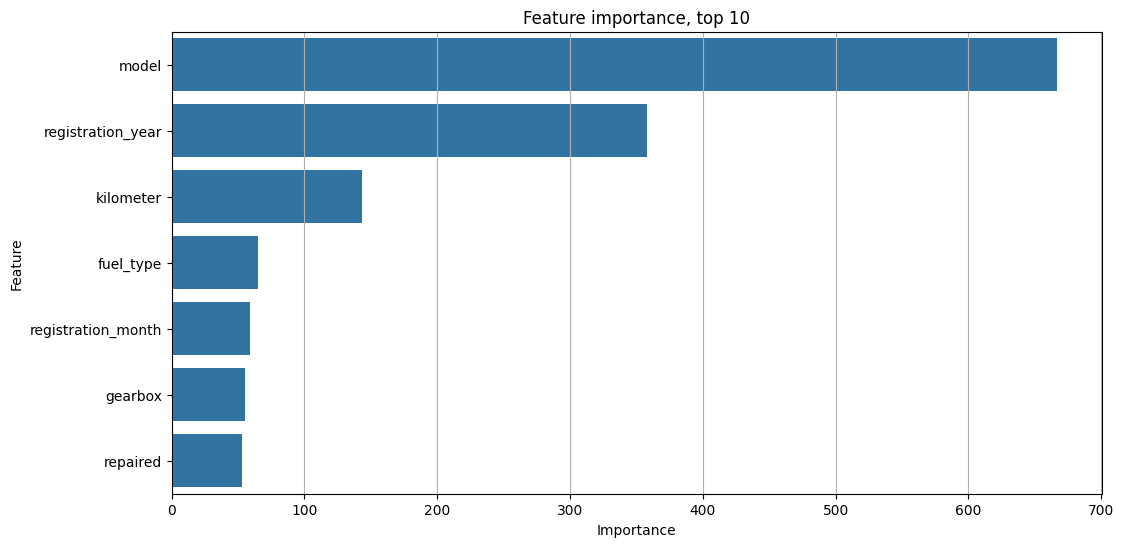

In [54]:
feature_importances = pd.DataFrame(
    {
        'Feature': cols_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)[:10]

plt.figure(figsize=(12, 6))
plt.title('Feature importance, top 10')
plt.grid()
sns.barplot(data=feature_importances, x='Importance', y='Feature');

Наиболее информативными признаками для модели являются: модель автомобиля, возраст и пробег.

**SHAP анализ**

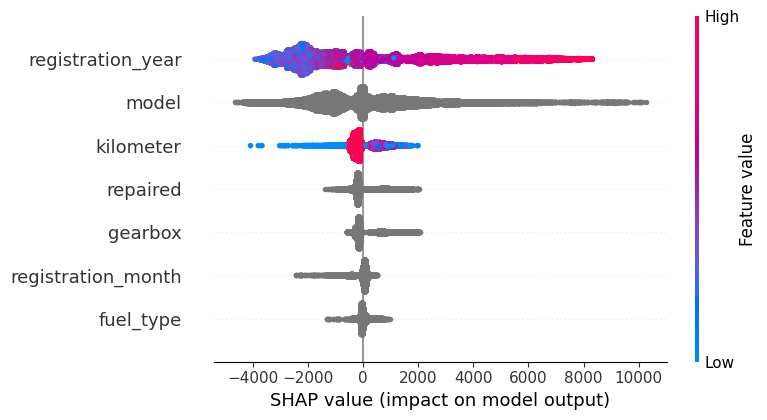

In [55]:
# 1. Создание TreeExplainer
explainer = shap.TreeExplainer(model)

# 2. Вычисление SHAP-значений
X_sample = pd.DataFrame(
    X_test_preprocessed,
    columns=cols_names
)
shap_values = explainer(X_test)

# 3. Визуализация
shap.summary_plot(shap_values, X_test, max_display=20)

Важность признаков по SHAP подтверждает выводы полученные методом анализа permutation_importance. 

**Анализ остатков**

In [56]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")
    plt.grid(True)
    plt.show()

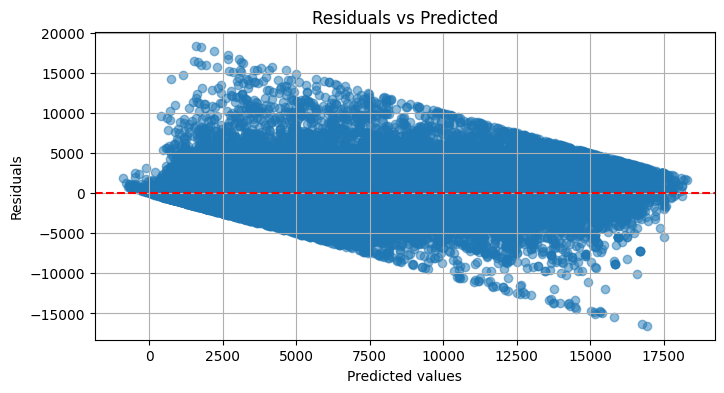

In [57]:
y_pred_final = model.predict(X_test)

plot_residuals(y_test, y_pred_final)

По анализу остатков можно сделать следующий вывод:
1. остатки неравномерны (гетероскедастичность) в среднем диапазоне самые большие остатки и по мере удаления от него, как в меньшую, так и в большую сторону остатки уменьшшаются
2. нет сильного смещения: точки примерно симметрично распределены вокруг нуля — это хорошо, признаков систематической ошибки не видно.

Все это говорит нам о том, что над моделью неоюходимо поработать.

**Промежуточные выводы**



Наиболее информативными признаками для модели являются: возраст автомобиля, пробег и история ремонтов.
1. остатки неравномерны (гетероскедастичность) в среднем диапазоне самые большие остатки и по мере удаления от него, как в меньшую, так и в большую сторону остатки уменьшшаются
2. нет сильного смещения: точки примерно симметрично распределены вокруг нуля что хорошо, признаков систематической ошибки не видно.

## Выводы

В результате исследования была решена задача построения модели для определения стоимости автомобиля по его характеристикам. Исходный датасет прошёл тщательную очистку и предобработку, устранены пропуски и аномалии, произведён корреляционный анализ и удалены признаки с избыточной информацией.

---

**После тестирования различных моделей выяснилось, что:**

- Модель **LGBMRegressor** показала наилучшее качество (**RMSE = 2080**) при высокой скорости обучения и предсказания.
- Наиболее значимыми признаками оказались: **модель автомобиля**, **возраст**, **пробег**, а также **история ремонтов**.
- Модель **не показывает систематических ошибок**, но демонстрирует **гетероскедастичность** — потенциальная точка роста в дальнейшей работе.

---

**Вывод:**  
Разработанная модель соответствует заявленным критериям (**RMSE < 2500**) и может быть рекомендована для промышленного использования с возможной доработкой и оптимизацией.